In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt 
import logging
import matplotlib.dates as mdates
   
PATH_TO_DATA = r'/Users/nadiiapoliakovska/Documents/Air_Pollution (Justin)'
PM25_pattern = r'Cal_PM2.5*.csv'
CO_pattern = r'Cal_CO*.csv'
EPA_O_3_pattern = r'EPA_O_3.csv'
    
class State:

    def __init__(self, path_to_folder, pattern):
        self.path_to_folder = path_to_folder
        self.pattern = pattern
    
    def create_df(self): 
        '''path_to_folder can be assigned to PATH_TO_DATA
        pattern for California is
        r'Cal_PM2.5*.csv' or
        r'Cal_CO*.csv' or
        r'EPA_O_3.csv' '''
        logging.basicConfig(level=logging.ERROR)
        files = glob.glob(os.path.join(self.path_to_folder, self.pattern))
        if len(files) > 1:
            df_list = []
            for i in files:
                df = pd.read_csv(i)
                df_list.append(df)
            big_df = pd.concat(df_list, ignore_index = True)
        elif len(files) == 1:
            big_df = pd.read_csv(files[0])
        else:
            big_df = "No files in the folder with this pattern"
        return big_df 
    
    def county_names(self):
        df = State(self.path_to_folder, self.pattern).create_df()
        return df['COUNTY'].unique()

In [13]:
class County(State):
    def __init__(self, path_to_folder, pattern, county): #county shoud be string
        super().__init__(path_to_folder, pattern)
        self.county = county
        
    def sub_df(self): 
        logging.basicConfig(level=logging.ERROR)
        df = super().create_df()
        if self.county in df['COUNTY'].unique():
            county_df = df.loc[df['COUNTY'] == self.county]
            county_df.loc[:,'Date'] = county_df.loc[:, 'Date'].apply(pd.to_datetime)
            county_df = county_df.sort_values(by=['Date'])
            ind = np.arange(0, len(county_df))
            county_df.set_index(ind, inplace = True)
        else: 
            print("No such county in this dataframe")
        return county_df
    
    def diff_values(self):
        logging.basicConfig(level=logging.ERROR)
        df = self.sub_df()
        l =[]
        for i in df.columns:
            if len(df[i].unique())!=1 :
                l.append(i)
        return l
    
    def sub_df_unique(self):
        df = self.sub_df()
        df_unique = df[['Date', 'Daily Mean PM2.5 Concentration', 'Site Name', 'SITE_LATITUDE', 'SITE_LONGITUDE']]
        df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)
        df_unique = df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
        df_unique['Month'] = pd.DatetimeIndex(df_unique['Date']).month
        df_unique['Year_Month'] = pd.DatetimeIndex(df_unique['Date']).to_period('M')
        df_unique['Year'] = pd.DatetimeIndex(df_unique['Date']).year
        return df_unique
    
    def preprocessed(self):
        logging.basicConfig(level=logging.ERROR)
        county_df_unique = self.sub_df()
           
        #county_df_unique = county_df[self.diff_values()]    
            
        if (county_df_unique['UNITS'].unique() != 'ug/m3 LC').any() or (len(county_df_unique['UNITS'].unique())==2):
            county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']
            county_df_unique['UNITS'] = county_df_unique['UNITS'].replace('ppm', 'ug/m3 LC')
        county_df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)
        
        if county_df_unique['Site Name'].isna().unique().all():
            county_df_unique == county_df_unique
        elif "Site Name" in county_df_unique.columns:
            county_df_unique = county_df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
        elif "COUNTY" in county_df_unique.columns:
            county_df_unique = county_df_unique.groupby(by= ["Date", "COUNTY"], as_index = False).mean()
        else:
            print('No COUNTY or Site Name in columns name of the ' + self.county + ' dataframe')
            for j in ["Site Name", "County"]:
                if j in county_df.columns:
                    county_df_unique = county_df_unique.join(county_df[j])
                    print("Joined " + j + " to " + self.county + '  unique dataframe')
                    county_df_unique = county_df_unique.groupby(by= ["Date", j], as_index = False).mean()
                else:
                    print("No " + j +" in "+ self.county + ' dataframe')
        
        county_df_unique['Month'] = pd.DatetimeIndex(county_df_unique['Date']).month
        county_df_unique['Year_Month'] = pd.DatetimeIndex(county_df_unique['Date']).to_period('M')
        county_df_unique['Year'] = pd.DatetimeIndex(county_df_unique['Date']).year

        return county_df_unique
    
    def county_plot_Daily_PM25(self):
        logging.basicConfig(level=logging.ERROR)
        df = self.preprocessed()
        %matplotlib inline
        plt.figure(figsize = (16, 10))
        x = df['Date']
        y = df['Daily Mean PM2.5 Concentration, ug/m3 LC']
        
            
        plt.stem(x, y, markerfmt=' ', basefmt=' ')  # No baseline for stems         
        # Beautify the x-axis by formatting dates
        #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())         
        plt.xlabel('Date', fontsize=20)
        plt.ylabel('Daily Mean PM2.5 Concentration, ug/m³ LC', fontsize=20)
        plt.title("Daily PM2.5 concentration changes with years for " + self.county + " county", fontsize=20)
        plt.grid()
        # Increase the font size of x and y ticks
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #California = super().create_df()
        #plt.xlim(pd.to_datetime(California["Date"].min(), format = '%m/%d/%Y'),
        #     pd.to_datetime(California["Date"].max(), format = '%m/%d/%Y'))
        #plt.ylim(California["Daily Mean PM2.5 Concentration"].min(), California["Daily Mean PM2.5 Concentration"].max())
        plt.savefig("Air_Pollution_plots/Daily PM2.5 concentration changes with years/Daily PM2.5 concentration changes with years for " + self.county + " county.pdf", format="pdf", bbox_inches="tight")
        # Show the plot
        plt.tight_layout()
        plt.show()

In [3]:
California = State(PATH_TO_DATA, EPA_O_3_pattern)
California_df = California.create_df()

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
Alameda = County(PATH_TO_DATA, EPA_O_3_pattern,'Alameda')
Alameda_df = Alameda.sub_df()
Alameda_df.head()

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Unnamed: 0,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,...,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,0,1980-01-01,AQS,60010004,1,0.003,ppm,3,Oakland-Jackson St.,17,...,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.800484,-122.266358
1,686,1980-01-01,AQS,60011002,1,0.017,ppm,16,Livermore - Railroad Ave.,17,...,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.682708,-121.770231
2,1277,1980-01-01,AQS,60015001,1,0.000,ppm,0,San Leandro-Thornton Ave.,17,...,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.718442,-122.160997
3,1038,1980-01-01,AQS,60012001,1,0.020,ppm,19,Hayward,17,...,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.654456,-122.031547
4,330,1980-01-01,AQS,60011001,1,0.010,ppm,9,Fremont - Chapel Way,17,...,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.535833,-121.961823


In [5]:
Alameda_df = Alameda_df.set_index('Unnamed: 0')
Alameda_df

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
0,1980-01-01,AQS,60010004,1,0.003,ppm,3,Oakland-Jackson St.,17,100,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.800484,-122.266358
686,1980-01-01,AQS,60011002,1,0.017,ppm,16,Livermore - Railroad Ave.,17,100,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.682708,-121.770231
1277,1980-01-01,AQS,60015001,1,0.000,ppm,0,San Leandro-Thornton Ave.,17,100,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.718442,-122.160997
1038,1980-01-01,AQS,60012001,1,0.020,ppm,19,Hayward,17,100,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.654456,-122.031547
330,1980-01-01,AQS,60011001,1,0.010,ppm,9,Fremont - Chapel Way,17,100,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.535833,-121.961823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364075,2022-08-11,AirNow,60010009,1,0.020,ppm,19,Oakland,24,100,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935
2364298,2022-08-11,AirNow,60010011,1,0.020,ppm,19,Oakland West,24,100,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.814781,-122.282347
2364076,2022-08-12,AirNow,60010009,1,0.023,ppm,21,Oakland,19,79,44201,Ozone,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.743065,-122.169935


In [6]:
Alameda_df['Month'] = pd.DatetimeIndex(Alameda_df['Date']).month
Alameda_df['Year_Month'] = pd.DatetimeIndex(Alameda_df['Date']).to_period('M')
Alameda_df['Year'] = pd.DatetimeIndex(Alameda_df['Date']).year

In [7]:
Alameda_df.loc[:,'Date'] = Alameda_df.loc[:, 'Date'].apply(pd.to_datetime)

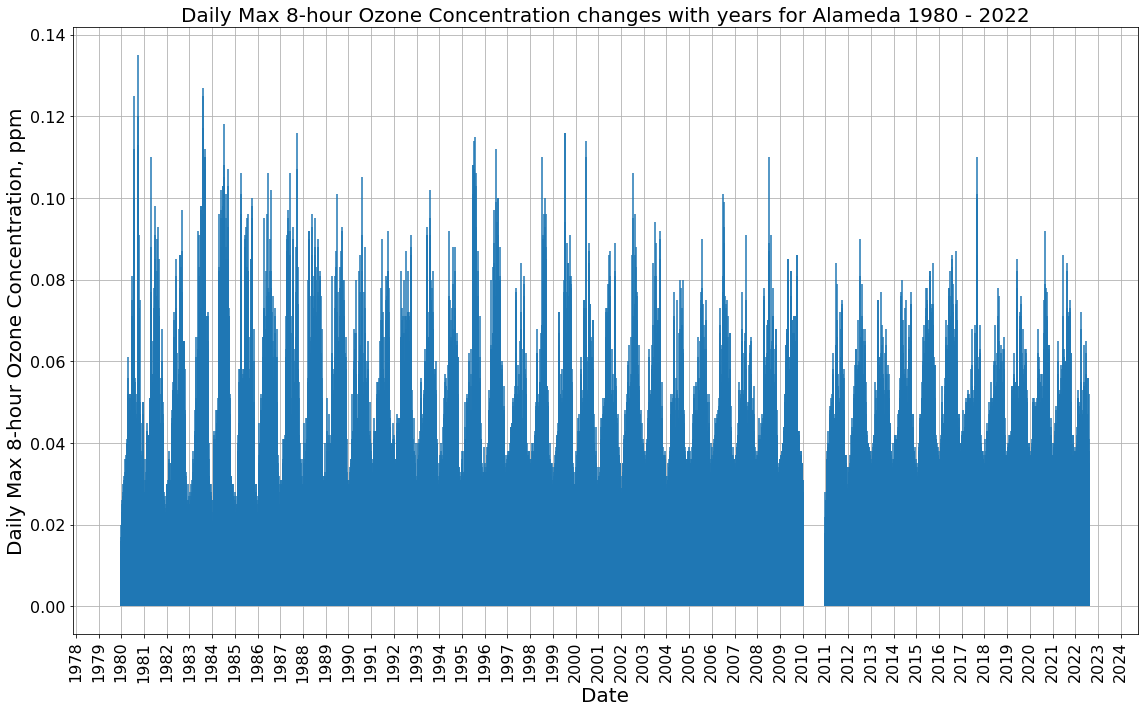

In [11]:
plt.figure(figsize = (16, 10))
x = Alameda_df['Date']
y = Alameda_df['Daily Max 8-hour Ozone Concentration']
        
plt.stem(x, y, markerfmt=' ', basefmt=' ')  # No baseline for stems         

plt.gca().xaxis.set_major_locator(mdates.YearLocator())         
plt.xlabel('Date', fontsize=20)
plt.ylabel('Daily Max 8-hour Ozone Concentration, ppm', fontsize=20)
plt.title("Daily Max 8-hour Ozone Concentration changes with years for Alameda 1980 - 2022", fontsize=20)
plt.grid()
# Increase the font size of x and y ticks
plt.xticks(fontsize=16, rotation = 90)
plt.yticks(fontsize=16)
plt.savefig("Presentation/Daily Max 8-hour Ozone Concentration changes with years for Alameda.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.tight_layout()
plt.show()

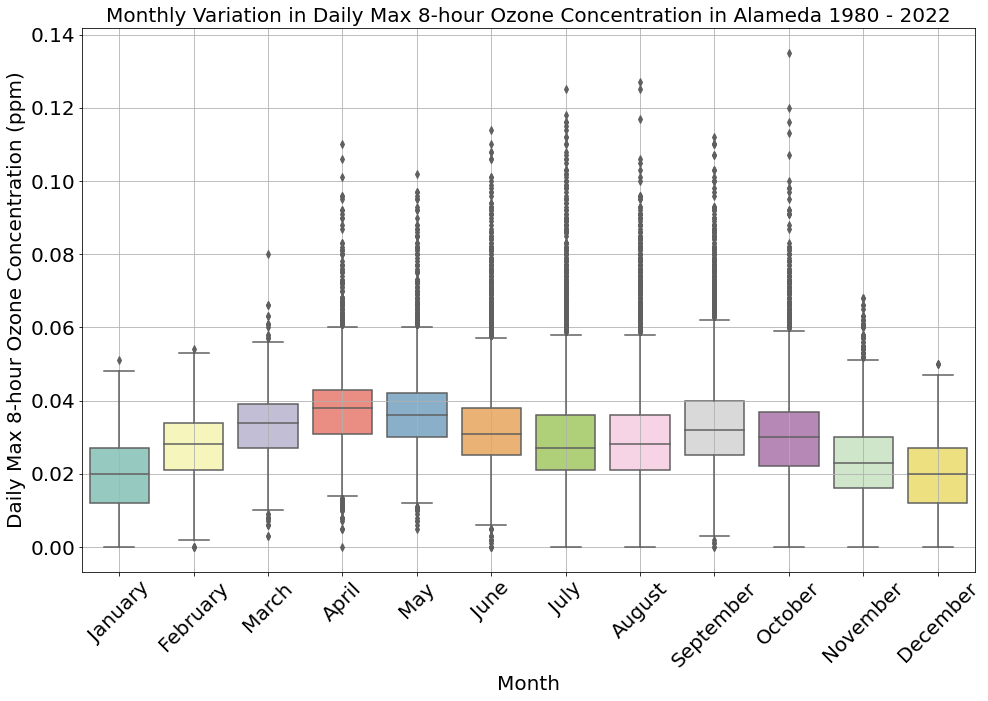

In [12]:
import seaborn as sns
import calendar
plt.figure(figsize=(16, 10))
sns.boxplot(x='Month', y='Daily Max 8-hour Ozone Concentration', data=Alameda_df, palette='Set3')
plt.title('Monthly Variation in Daily Max 8-hour Ozone Concentration in Alameda 1980 - 2022', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Daily Max 8-hour Ozone Concentration (ppm)', fontsize=20)
plt.grid()

plt.xticks(np.arange(0, 12), calendar.month_name[1:], rotation=45, fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("Presentation/Boxplot - Monthly Variation in Daily Max 8-hour Ozone Concentration for Alameda.pdf", format="pdf", bbox_inches="tight")
plt.show()